# Face Alignment by Hourglass (84 landmarks)

In [1]:
import sys
sys.path.append('..')
import menpo
import tensorflow as tf
import menpo.io as mio
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.python.platform import tf_logging as logging
from menpo.image import Image
from menpo.shape import PointCloud

import numpy as np
import menpo.io as mio
import scipy.io as sio
from io import BytesIO
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xml.etree.ElementTree as ET
import json
import glob
import cv2
import scipy
import os
import os.path
from menpo.image import Image
from menpo.visualize import print_dynamic, print_progress
from scipy.spatial.distance import pdist
from pathlib import Path

from menpo.shape import PointCloud, PointUndirectedGraph
from menpo.transform import Translation, Scale
from menpofit.transform import DifferentiableAlignmentSimilarity

from menpowidgets import visualize_images
from PIL import Image as PImage
import numpy as np
import cmhm3dfa.detect_face as detect_face
from cmhm3dfa.flags import FLAGS
import cmhm3dfa.networks as networks
from cmhm3dfa.utils import tf_heatmap_to_lms, crop_image_bounding_box
import matplotlib.pyplot as plt
import pylab
import tensorflow as tf
np.set_printoptions(3)
slim = tf.contrib.slim
%matplotlib inline

In [2]:
minsize = 40 # minimum size of face
threshold = [ 0.3, 0.5, 0.8 ]  # three steps's threshold
factor = 0.709 # scale factor
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Graph().as_default():
    sess = tf.Session(config=config)
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_detector(sess, '../cmhm3dfa/pretrained_mtcnn')

In [3]:
# Unzip pre-trained model in home folder - https://drive.google.com/open?id=1DKTeRlJjyo_tD1EluDjYLhtKFPJ9vIVd
assert(os.path.exists(os.path.expanduser('~/ckpt/3D84'))) 
model_path = os.path.expanduser('~/ckpt/3D84/model.ckpt-277538')
n_landmarks = 84
FLAGS.n_landmarks = 84
with tf.Graph().as_default() as g:
    images_input = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='input_images')
    net_model = networks.DNFaceMultiView('')
    with tf.variable_scope('net'):
        lms_heatmap_prediction,states = net_model._build_network(images_input, datas=None, is_training=False, n_channels=n_landmarks)
        pts_predictions = tf_heatmap_to_lms(lms_heatmap_prediction)
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config,graph=g)
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from /home/mathieu/ckpt/3D84/model.ckpt-277538


In [4]:
image_path = '../image/test.jpg'
template = mio.import_pickle('../image/template.pkl.gz')
image = mio.import_image(image_path)
image_path = image.path
image_ID_name = image_path.stem
bounding_boxes, points = detect_face.detect_face(image.pixels_with_channels_at_back() * 255, minsize, pnet, rnet, onet, threshold, factor)
print('Box Number: %s' % bounding_boxes.shape[0])
batch_pixels = []
batch_trans = []
batch_image_names = []

for box_index in np.arange(bounding_boxes.shape[0]):    
    bbox = PointCloud(bounding_boxes[box_index,[1,0,3,2]].reshape([2,2])).bounding_box()
    crop_img, crop_trans = crop_image_bounding_box(image, bbox, [256., 256.], base=256./256., order=1)
    input_pixels = crop_img.pixels_with_channels_at_back()
    batch_pixels.append(input_pixels)
    batch_trans.append(crop_trans)
    batch_image_names.append('../image/' + image_ID_name + '__' + str(box_index) + '.pts')
    
pts_pred = sess.run(
    pts_predictions,
    feed_dict={images_input: np.stack(batch_pixels, axis=0)})

for inner_batch_index in np.arange(bounding_boxes.shape[0]):
    orig_pts = batch_trans[inner_batch_index].apply(PointCloud(pts_pred[inner_batch_index]))
    template.landmarks['SAVEPTS'] = orig_pts
    mio.export_landmark_file(template.landmarks['SAVEPTS'], batch_image_names[inner_batch_index],extension='pts', overwrite=True)

/home/mathieu/miniconda3/envs/lab/lib/python3.6/site-packages/menpo/shape/labelled.py:212: MenpoDeprecationWarning: menpo.landmark.LandmarkGroup is now deprecated and has been moved to menpo.shape.LandmarkGroup.
  MenpoDeprecationWarning)


Box Number: 33


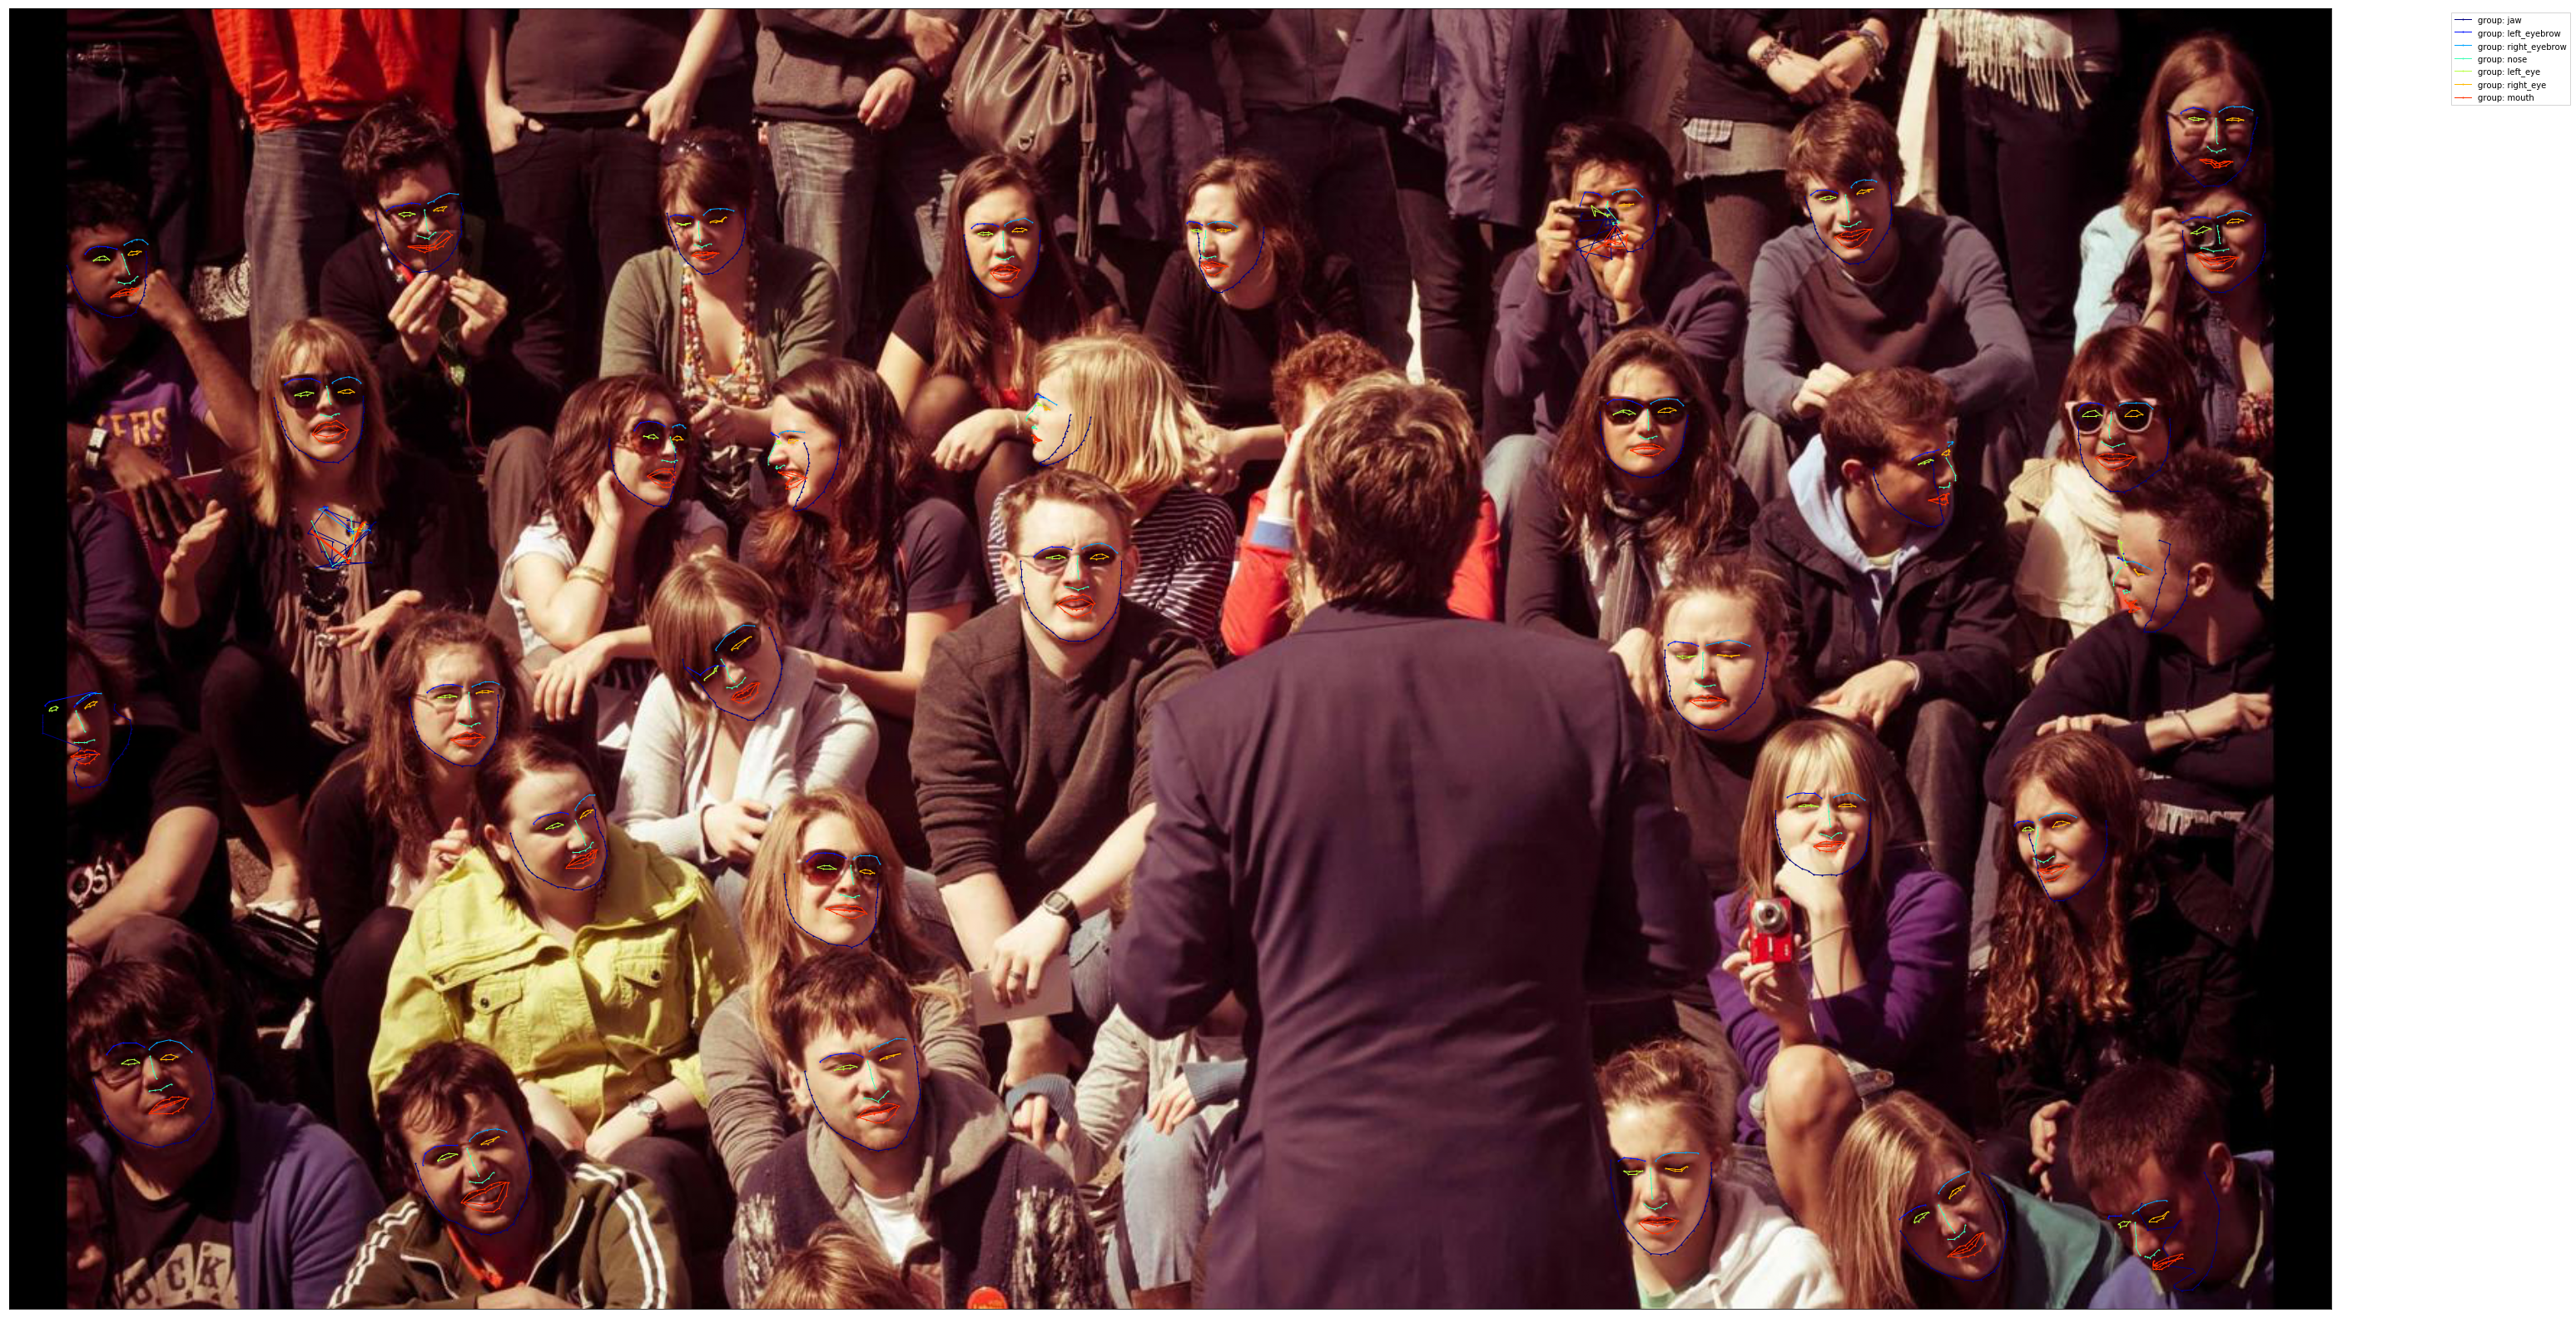

In [5]:
image.view(figure_size=(50,50))
for inner_batch_index in np.arange(bounding_boxes.shape[0]):
    image.landmarks['PTS']= mio.import_landmark_file(batch_image_names[inner_batch_index])
    template.landmarks['LJSON'].points = image.landmarks['PTS'].points
    lm = template.landmarks['LJSON']
    lm.view(marker_size=1,figure_size=(50,50))    